# SWCON425 Data Science and Visualization
# Practical Statistics for Data Scientists
## Data and Sampling Distributions

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

DATA = Path('.').resolve().parents[1] / 'data'

/Users/annbeomsu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

# Population versus Sample

<img src="population_vs_sample.png">

A *sample* is a subset of data from a larger data set; statisticians call this larger data set the *population*. 

*Random sampling* is a process in which each available member of the population being sampled has an equal chance of being chosen for the sample at each draw. 

The sample that results is called a *simple random sample*. Sampling can be done with *replacement*, in which observations are put back in the population after each draw for possible future reselection. 

Or it can be done *without replacement*, in which case observations, once selected, are unavailable for future draws.



Data quality often matters more than data quantity when making an estimate or a model based on a sample. 

Data quality in data science involves completeness, consistency of format, cleanliness, and accuracy of individual data points. 

Statistics adds the notion of *representativeness*.

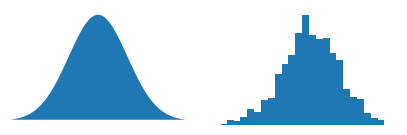

In [9]:
np.random.seed(seed=1)
x = np.linspace(-3, 3, 300)
xsample = stats.norm.rvs(size=1000)
# A normal continuous random variable
fig, axes = plt.subplots(ncols=2, figsize=(5, 1.5))

ax = axes[0]
##### # probability density function (pdf)
ax.fill(x, stats.norm.pdf(x))
ax.set_axis_off()
ax.set_xlim(-3, 3)

ax = axes[1]
ax.hist(xsample, density=True, bins=30)
ax.set_axis_off()
ax.set_xlim(-3, 3)
ax.set_position
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
   
plt.show()

This figure shows a schematic that underpins the concepts — data and sampling distributions. 

The lefthand side represents a population that, in statistics, is assumed to follow an underlying but *unknown* distribution.

All that is available is the *sample* data and its empirical distribution, shown on the righthand side. 

To get from the lefthand side to the righthand side, a sampling procedure is used. 

Traditional statistics focused very much on the lefthand side, using theory based on strong assumptions about the population. 

Modern statistics has moved to the righthand side, where such assumptions are not needed.

# Sampling Distribution of a Statistic

The term *sampling distribution* of a statistic refers to the distribution of some sample statistic over many samples drawn from the same population. 

Much of classical statistics is concerned with making inferences from (small) samples to (very large) populations.

Typically, a sample is drawn with the goal of measuring something (with a *sample statistic*) or modeling something (with a statistical or machine learning model). 

Since our estimate or model is based on a sample, it might be in error; it might be different if we were to draw a different sample. We are therefore interested in how different it might be—a key concern is *sampling variability*.

If we had lots of data, we could draw additional samples and observe the distribution of a sample statistic directly.

The distribution of a sample statistic such as the mean is likely to be more regular and bell-shaped than the distribution of the data itself. 

The larger the sample the statistic is based on, the more this is true. Also, the larger the sample, the narrower the distribution of the sample statistic.

In [10]:
# This is illustrated in an example using annual income for loan applicants

loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze=True)

# take a simple random sample
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

# take a sample of means of 5 values
sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

# take a sample of means of 20 values
sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
#print(results.head())
results.head(10)

/var/folders/19/l4jmmtl54430h_n57ccs701w0000gn/T/ipykernel_48929/2201576856.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze=True)


,income,type
40292,63000.0,Data
38959,92000.0,Data
17361,134000.0,Data
33996,52000.0,Data
26491,43000.0,Data
32173,41000.0,Data
22152,50000.0,Data
1218,62000.0,Data
116,93000.0,Data
11904,60000.0,Data


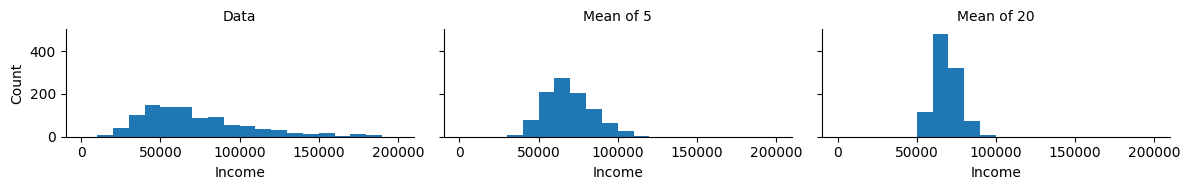

In [11]:
# Plot a histogram of each sample 
g = sns.FacetGrid(results, col='type', height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=20)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

This figure shows the histogram of annual incomes of 
* 1,000 loan applicants (left) 
* 1,000 means of n=5 applicants (middle) 
* 1,000 means of n=20 applicants (right)

# The Bootstrap

One easy and effective way to estimate the sampling distribution of a statistic, or of model parameters, is to draw additional samples, with replacement, from the sample itself and recalculate the statistic or model for each resample. 


This procedure is called the *bootstrap*, and it does not necessarily involve any assumptions about the data or the sample statistic being normally distributed.

### Key terms for the bootstrap 
* **Bootstrap sample** - A sample taken with replacement from an observed data set
* **Resampling** - The process of taking repeated samples from observed data; includes both bootstrap and permulation (shuffling) procedures

Conceptually, you can imagine the bootstrap as replicating the original sample thousands or millions of times so that you have a hypothetical population that embodies all the knowledge from your original sample (it’s just larger). 

You can then draw samples from this hypothetical population for the purpose of estimating a sampling distribution.

<img src="basic_bootstrap.png">

In practice, it is not necessary to actually replicate the sample a huge number of times. 

We simply replace each observation after each draw; that is, we *sample* with *replacement*. 

In this way we effectively create an infinite population in which the probability of an element being drawn remains unchanged from draw to draw. 

The algorithm for a bootstrap resampling of the mean, for a sample of size n, is as follows:

1. Draw a sample value, record it, and then replace it.
2. Repeat n times.
3. Record the mean of the n resampled values.
4. Repeat steps 1–3 R times.
5. Use the R results to:<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a. Calculate their standard deviation (this estimates sample mean standard error).<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b. Produce a histogram or boxplot.<br /> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c. Find a confidence interval.<br />

R, the number of iterations of the bootstrap, is set somewhat arbitrarily. 

The more iterations you do, the more accurate the estimate of the standard error, or the confidence interval. 

The result from this procedure is a bootstrap set of sample statistics or estimated model parameters, which you can then examine to see how variable they are.

In [12]:
results = []
for nrepeat in range(1000):
    # using scikit-learn resample method
    sample = resample(loans_income)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results.mean() - loans_income.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -82.09799999999814
std. error: 228.73933106830748


The original estimate of the median is 62,000. 
The bootstrap distribution indicates that the estimate has a bias of about 70 and a standard error of 209. 
The results will vary slightly between consecutive runs of the algorithm.

# Confidence Intervals

Frequency tables, histograms, boxplots, and standard errors are all ways to understand the potential error in a sample estimate. Confidence intervals are another.

There is a natural human aversion to uncertainty; people (especially experts) say “I don’t know” far too rarely. 

Analysts and managers, while acknowledging uncertainty, nonetheless place undue faith in an estimate when it is presented as a single number (a point estimate). 

Presenting an estimate not as a single number but as a range is one way to counteract this tendency. 

Confidence intervals do this in a manner grounded in statistical sampling principles.

Confidence intervals always come with a coverage level, expressed as a (high) percentage, say 90% or 95%. 

One way to think of a 90% confidence interval is as follows: it is the interval that encloses the central 90% of the bootstrap sampling distribution of a sample statistic.

More generally, an x% confidence interval around a sample estimate should, on average, contain similar sample estimates x% of the time (when a similar sampling procedure is followed).

Given a sample of size n, and a sample statistic of interest, the algorithm for a bootstrap confidence interval is as follows:
1. Draw a random sample of size n with replacement from the data (a resample).
2. Record the statistic of interest for the resample.
3. Repeat steps 1–2 many (R) times.
4. For an x% confidence interval, trim [(100-x) / 2]% of the R resample results from either end of the distribution.
5. The trim points are the endpoints of an x% bootstrap confidence interval.


### Key Terms for Confidence Intervals

* **Confidence level**<br/>
The percentage of confidence intervals, constructed in the same way from the same population, that are expected to contain the statistic of interest.

* **Interval endpoints**<br/>
The top and bottom of the confidence interval.

68760.51844
55734.1


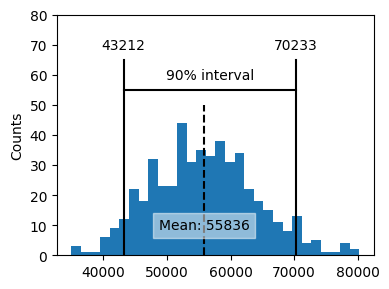

In [14]:
print(loans_income.mean())
np.random.seed(seed=3)  
# create a sample of 20 loan income data

sample20 = resample(loans_income, n_samples=20, replace=False)
print(sample20.mean())
results = []

for nrepeat in range(500):
        sample = resample(sample20)
        results.append(sample.mean())
results = pd.Series(results)

confidence_interval = list(results.quantile([0.05, 0.95]))
ax = results.plot.hist(bins=30, figsize=(4, 3))
ax.plot(confidence_interval, [55, 55], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}', 
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')

meanIncome = results.mean()
ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
ax.text(meanIncome, 10, f'Mean: {meanIncome:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

This figure shows a 90% confidence interval for the mean annual income of loan
applicants, based on a sample of 20 for which the mean was $62,231.

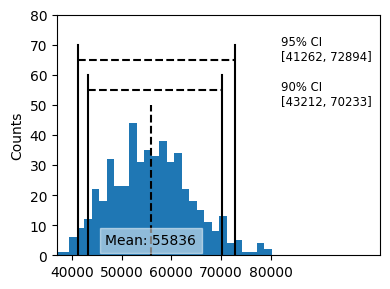

In [15]:
np.random.seed(seed=3)
# create a sample of 20 loan income data
sample20 = resample(loans_income, n_samples=20, replace=False)

results = []
for nrepeat in range(500):
    sample = resample(sample20)
    results.append(sample.mean())
results = pd.Series(results)

confidence_interval = list(results.quantile([0.05, 0.95]))
ax = results.plot.hist(bins=30, figsize=(4, 3), color='C1')
ax.plot(confidence_interval, [55, 55], color='black', linestyle='--')
for x in confidence_interval:
    ax.plot([x, x], [0, 60], color='black')
ax.text(82000, 50, 
        f'90% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
       fontsize='small')

confidence_interval = list(results.quantile([0.025, 0.975]))
ax = results.plot.hist(bins=30, figsize=(4, 3))
ax.plot(confidence_interval, [65, 65], color='black', linestyle='--')
for x in confidence_interval:
    ax.plot([x, x], [0, 70], color='black')
ax.text(82000, 65, 
        f'95% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
       fontsize='small')
# ax.text(sum(confidence_interval) / 2, 264, '95 % interval',
#         horizontalalignment='center', verticalalignment='center')

meanIncome = results.mean()
ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
ax.text(meanIncome, 5, f'Mean: {meanIncome:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_xlim(37000, 102000)
ax.set_xticks([40000, 50000, 60000, 70000, 80000])
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

### Key Ideas

* Confidence intervals are the typical way to present estimates as an interval range.
* The more data you have, the less variable a sample estimate will be.
* The lower the level of confidence you can tolerate, the narrower the confidence interval will be.
* The bootstrap is an effective way to construct confidence intervals.


# Normal Distribution

The bell-shaped normal distribution is iconic in traditional statistics. 

The fact that distributions of sample statistics are often normally shaped has made it a powerful tool in the development of mathematical formulas that approximate those distributions.


In a normal distribution, 68% of the data lies within one standard deviation of the mean, and 95% lies within two standard deviations.

<img src="normal_dist.png">

### Key terms for the normal distribution 

* **Error**<br/>
The difference between a data point and a predicted or average value.

* **Standardize**<br/>
Subtract the mean and divide by the standard deviation.

* **z-score**<br/>
The result of standardizing an individual data point.

* **Standard normal**<br/>
A normal distribution with mean = 0 and standard deviation = 1.

* **QQ-Plot**<br/>
A plot to visualize how close a sample distribution is to a specified distribution, e.g., the normal distribution.


## Standard Normal and QQ-Plots

A *standard normal distribution* is one in which the units on the x-axis are expressed in terms of standard deviations away from the mean. 

To compare data to a standard normal distribution, you subtract the mean and then divide by the standard deviation; this is also called *normalization* or *standardization*. 

Note that “standardization” in this sense is unrelated to database record standardization (conversion to a common format). 

The transformed value is termed a *z-score*, and the normal distribution is sometimes called the *z-distribution*.

A *QQ-Plot* is used to visually determine how close a sample is to a specified distribution—in this case, the normal distribution. 

The QQ-Plot orders the z-scores from low to high and plots each value’s z-score on the y-axis; the x-axis is the corresponding quantile of a normal distribution for that value’s rank. 

Since the data is normalized, the units correspond to the number of standard deviations away from the mean. 

If the points roughly fall on the diagonal line, then the sample distribution can be considered close to normal.

Converting data to z-scores (i.e., standardizing or normalizing the data) does not make the data normally distributed. 

It just puts the data on the same scale as the standard normal distribution, often for comparison purposes.

The package _scipy_ has the function (`scipy.stats.probplot`) to create QQ-plots. The argument `dist` specifies the distribution, which is set by default to the normal distribution.

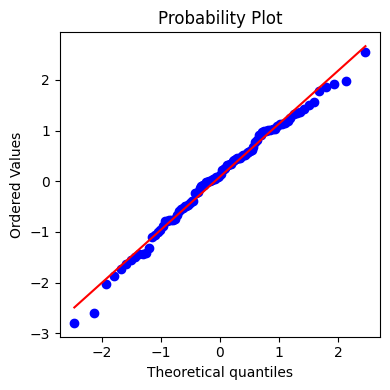

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))

norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()
plt.show()

This figure shows a QQ-Plot for a sample of 100 values randomly generated from a normal distribution; as expected, the points closely follow the line. 

### Key Ideas

* The normal distribution was essential to the historical development of statistics, as it permitted mathematical approximation of uncertainty and variability.
* While raw data is typically not normally distributed, errors often are, as are averages and totals in large samples.
* To convert data to z-scores, you subtract the mean of the data and divide by the standard deviation; you can then compare the data to a normal distribution.



# Long-Tailed Distributions

Despite the importance of the normal distribution historically in statistics, and in contrast to what the name would suggest, data is generally not normally distributed.

While the normal distribution is often appropriate and useful with respect to the distribution of errors and sample statistics, it typically does not characterize the distribution of raw data. 

Sometimes, the distribution is highly skewed (asymmetric), such as with income data; or the distribution can be discrete, as with binomial data. 

Both symmetric and asymmetric distributions may have long tails. 

The tails of a distribution correspond to the extreme values (small and large). Long tails, and guarding against them, are widely recognized in practical work.

### Key Terms for Long-Tailed Distributions
* **Tail** - The long narrow portion of a frequency distribution, where relatively extreme values occur at low frequency.

* **Skew** - Where one tail of a distribution is longer than the other.


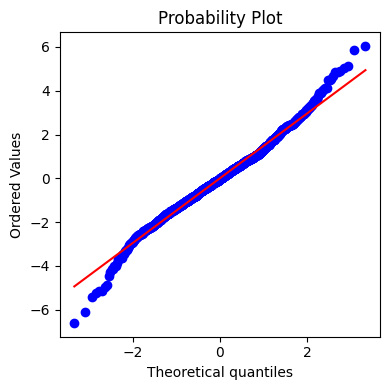

In [17]:
sp500_px = pd.read_csv(SP500_DATA_CSV)

nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0]))

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(nflx, plot=ax)

plt.tight_layout()
plt.show()

In contrast to QQ-plot for normal distribution, the points are far below the line for low values and far above the line for high values, indicating the data are not normally distributed. 

This means that we are much more likely to observe extreme values than would be expected if the data had a normal distribution. 

This figure shows another common phenomenon: the points are close to the line for the data within one standard deviation of the mean. 

Tukey refers to this phenomenon as data being “normal in the middle” but having much longer tails.

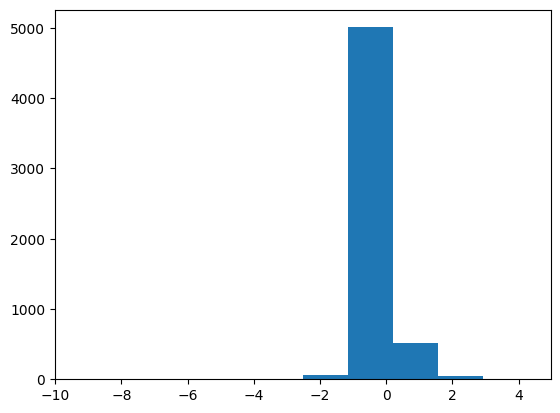

In [18]:
#plt.hist(sp500_px.NFLX)

nflx = sp500_px.NFLX
#nflx = np.log(nflx[nflx>0])
#nflx = np.diff(np.log(nflx[nflx>0]))

plt.hist(nflx)
plt.show()

### Key Ideas

* Most data is not normally distributed.
* Assuming a normal distribution can lead to underestimation of extreme events.

# Summary

In the era of big data, the principles of random sampling remain important when accurate estimates are needed. 

Random selection of data can reduce bias and yield a higher quality data set than would result from just using the conveniently available data.

Knowledge of various sampling and data-generating distributions allows us to quantify potential errors in an estimate that might be due to random variation. 

At the same time, the bootstrap (sampling with replacement from an observed data set) is an attractive “one size fits all” method to determine possible error in sample estimates.